# Wasserstein GAN with Gradient Penalty (WGAN-GP)

### Goals
In this notebook, we're going to build a Wasserstein GAN with Gradient Penalty (WGAN-GP) that solves some of the stability issues with the GANs that we have been using up until this point. Specifically, qw'll use a special kind of loss function known as the W-loss, where W stands for Wasserstein, and gradient penalties to prevent mode collapse.

*Fun Fact: Wasserstein is named after a mathematician at Penn State, Leonid Vaseršteĭn. qw'll see it abbreviated to W (e.g. WGAN, W-loss, W-distance).*


## Generator and Critic

We will begin by importing some useful packages, defining visualization functions, building the generator, and building the critic. Since the changes for WGAN-GP are done to the loss function during training, Remember that in WGAN-GP, we no longer use a discriminator that classifies fake and real as 0 and 1 but rather a critic that scores images with real numbers.

#### Packages and Visualizations

In [3]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!
from torchvision.utils import save_image
from IPython.display import Image
import os

sample_dir = 'Generated'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

def show_tensor_fimages(image_tensor,index,step, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    save_image(image_unflat[:num_images], os.path.join(sample_dir, fake_fname), nrow=5)
    #plt.imsave(os.path.join(sample_dir, fake_fname),arr=image_grid.permute(1, 2, 0).squeeze())
    plt.show()
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def make_grad_hook():
    '''
    Function to keep track of gradients for visualization purposes, 
    which fills the grads list when using model.apply(grad_hook).
    '''
    grads = []
    def grad_hook(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            grads.append(m.weight.grad)
    return grads, grad_hook

#### Generator and Noise

In [4]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
      n_samples: the number of samples to generate, a scalar
      z_dim: the dimension of the noise vector, a scalar
      device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

#### Critic

In [5]:
class Critic(nn.Module):
    '''
    Critic Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Critic, self).__init__()
        self.crit = nn.Sequential(
            self.make_crit_block(im_chan, hidden_dim),
            self.make_crit_block(hidden_dim, hidden_dim * 2),
            self.make_crit_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_crit_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a critic block of DCGAN;
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the critic: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        crit_pred = self.crit(image)
        return crit_pred.view(len(crit_pred), -1)

## Training Initializations
Now we can start putting it all together.
As usual, we will start by setting the parameters:
  *   n_epochs: the number of times we iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   beta_1, beta_2: the momentum terms
  *   c_lambda: weight of the gradient penalty
  *   crit_repeats: number of times to update the critic per generator update - there are more details about this in the *Putting It All Together* section
  *   device: the device type

We will also load and transform the MNIST dataset to tensors.




In [7]:
n_epochs = 100
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw



Then, we can initialize your generator, critic, and optimizers.

In [18]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Critic().to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)


## Gradient Penalty
Calculating the gradient penalty can be broken into two functions: (1) compute the gradient with respect to the images and (2) compute the gradient penalty given the gradient.

We can start by getting the gradient. The gradient is computed by first creating a mixed image. This is done by weighing the fake and real image using epsilon and then adding them together. Once 23 have the intermediate image, we can get the critic's output on the image. Finally, we compute the gradient of the critic score's on the mixed images (output) with respect to the pixels of the mixed images (input). 

In [ ]:
# FUNCTION: get_gradient
def get_gradient(crit, real, fake, epsilon):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    '''
    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        # Note: we need to take the gradient of outputs with respect to inputs.
        # This documentation may be useful, but it should not be necessary:
        # https://pytorch.org/docs/stable/autograd.html#torch.autograd.grad
        inputs=mixed_images,
        outputs=mixed_scores,
        # These other parameters have to do with the pytorch autograd engine works
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient


Next  to compute the gradient penalty given the gradient. First, we calculate the magnitude of each image's gradient. The magnitude of a gradient is also called the norm. Then, we can calculate the penalty by squaring the distance between each magnitude and the ideal norm of 1 and taking the mean of all the squared distances.

In [ ]:
# gradient_penalty
def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, we calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    Returns:
        penalty: the gradient penalty
    '''
    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)
    
    # Penalize the mean squared distance of the gradient norms from 1
    penalty = torch.mean((gradient_norm-1)**2)

    return penalty

## Losses
Next, we need to calculate the loss for the generator and the critic.

For the generator, the loss is calculated by maximizing the critic's prediction on the generator's fake images. The argument has the scores for all fake images in the batch, but we will use the mean of them.

In [ ]:
# FUNCTION: get_gen_loss
def get_gen_loss(crit_fake_pred):
    '''
    Return the loss of a generator given the critic's scores of the generator's fake images.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
    Returns:
        gen_loss: a scalar loss value for the current batch of the generator
    '''

    gen_loss =-1. * torch.mean(crit_fake_pred)

    return gen_loss

For the critic, the loss is calculated by maximizing the distance between the critic's predictions on the real images and the predictions on the fake images while also adding a gradient penalty. The gradient penalty is weighed according to lambda. The arguments are the scores for all the images in the batch, and we will use the mean of them.


In [ ]:
# FUNCTION: get_crit_loss
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    '''
    Return the loss of a critic given the critic's scores for fake and real images,
    the gradient penalty, and gradient penalty weight.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
        crit_real_pred: the critic's scores of the real images
        gp: the unweighted gradient penalty
        c_lambda: the current weight of the gradient penalty 
    Returns:
        crit_loss: a scalar for the critic's loss, accounting for the relevant factors
    '''

    crit_loss = torch.mean(crit_fake_pred)-torch.mean(crit_real_pred)+gp*c_lambda

    return crit_loss

In [2]:
import os

sample_dir = 'Generated'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

## Putting It All Together
Before we put everything together, there are a few things to note.
1.   Even on GPU, the **training will run more slowly** than previous labs because the gradient penalty requires we to compute the gradient of a gradient -- this means potentially a few minutes per epoch! For best results, run this for as long as we can while on GPU.
2.   One important difference from earlier versions is that we will **update the critic multiple times** every time we update the generator This helps prevent the generator from overpowering the critic. Sometimes, we might see the reverse, with the generator updated more times than the critic. This depends on architectural (e.g. the depth and width of the network) and algorithmic choices (e.g. which loss we're using). 
3.   WGAN-GP isn't necessarily meant to improve overall performance of a GAN, but just **increases stability** and avoids mode collapse. In general, a WGAN will be able to train in a much more stable way than the vanilla DCGAN from last assignment, though it will generally run a bit slower. We should also be able to train our model for more epochs without it collapsing


<!-- Once again, be warned that this runs very slowly on a CPU. One way to run this more quickly is to download the .ipynb and upload it to Google Drive, then open it with Google Colab and make the runtime type GPU and replace
`device = "cpu"`
with
`device = "cuda"`
and make sure that your `get_noise` function uses the right device.  -->


Epoch 1, step 500: Generator loss: 3.609848633029498, critic loss: -106.36745792694826


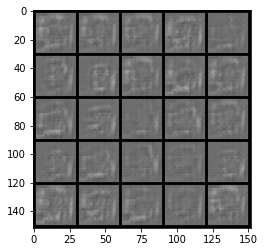

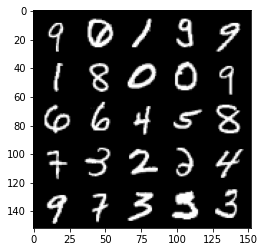

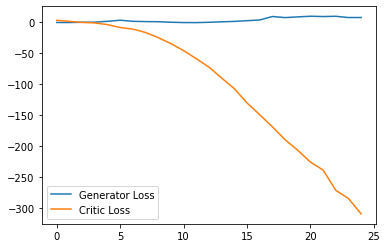

Epoch 2, step 1000: Generator loss: -18.02415939235687, critic loss: -189.3231965980531


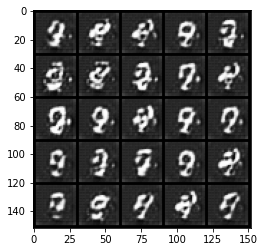

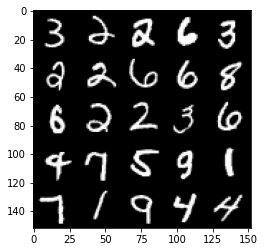

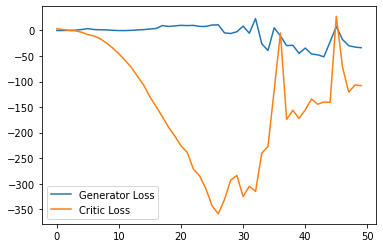

Epoch 3, step 1500: Generator loss: 11.167352115631104, critic loss: 33.70035641918184


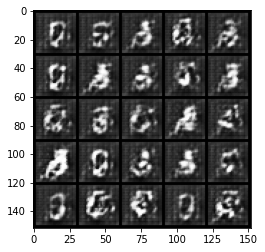

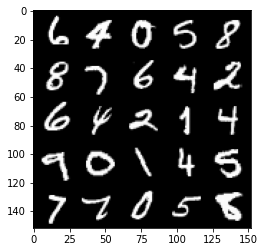

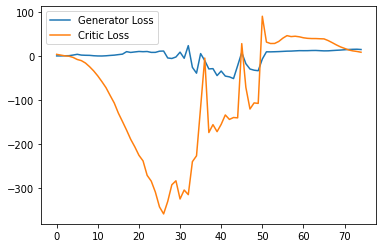

Epoch 4, step 2000: Generator loss: 15.978783498764038, critic loss: -2.656039568710328


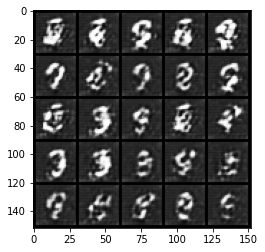

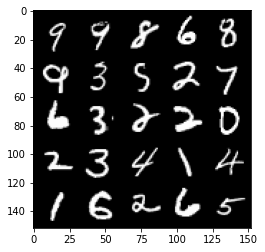

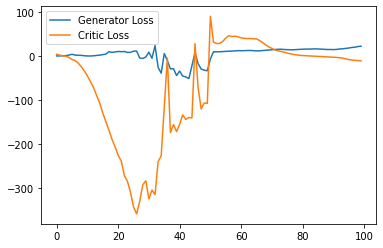

Epoch 5, step 2500: Generator loss: 27.29498124858737, critic loss: -20.202917712020856


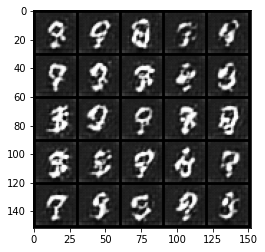

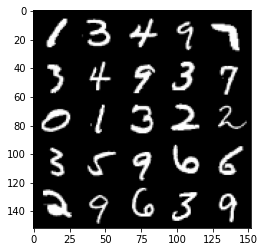

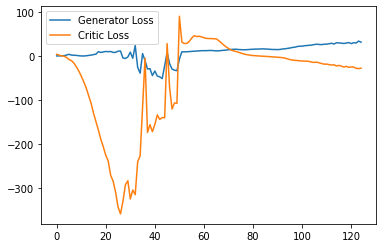

Epoch 6, step 3000: Generator loss: 30.584617651581762, critic loss: -25.07203701810836


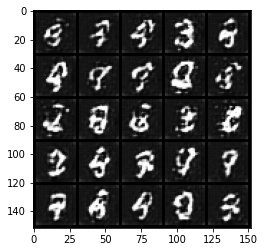

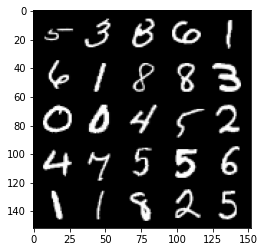

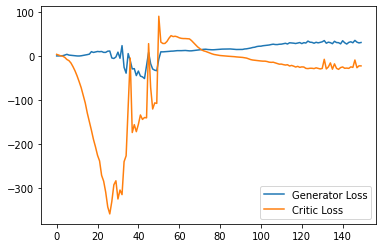

Epoch 7, step 3500: Generator loss: 32.79464584988356, critic loss: -11.155902333498004


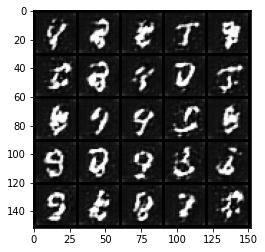

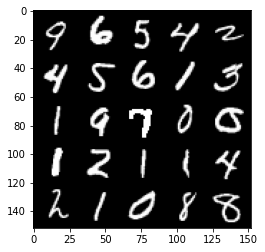

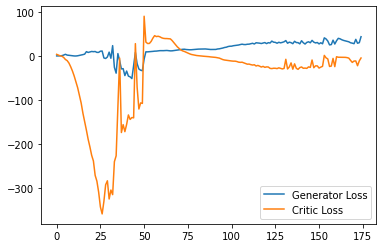

Epoch 8, step 4000: Generator loss: 38.176428845644, critic loss: -8.315888882541659


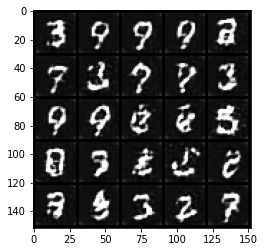

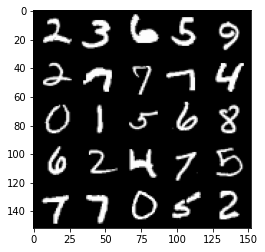

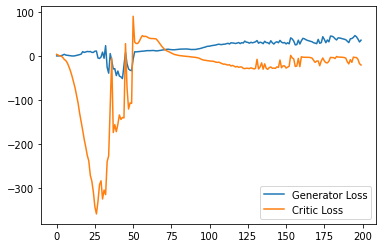

Epoch 9, step 4500: Generator loss: 41.327863819122314, critic loss: -4.396588967609404


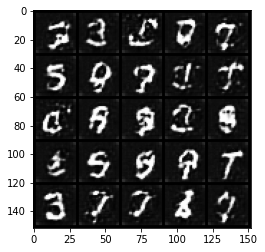

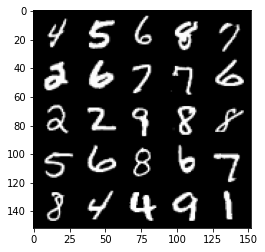

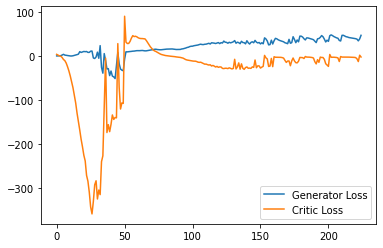

Epoch 10, step 5000: Generator loss: 41.21263980484009, critic loss: -7.3713138794898985


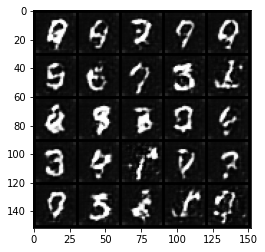

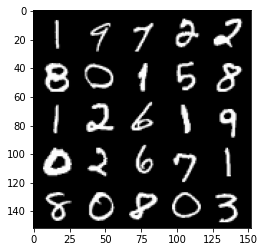

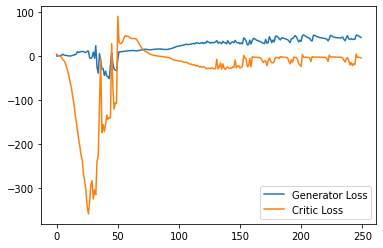

Epoch 11, step 5500: Generator loss: 41.034268173217775, critic loss: -11.513883823919288


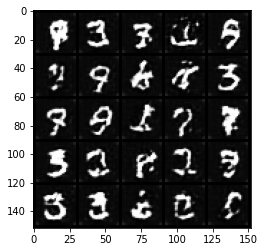

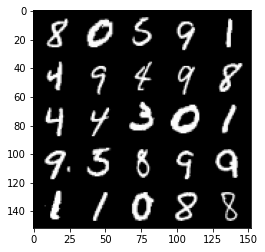

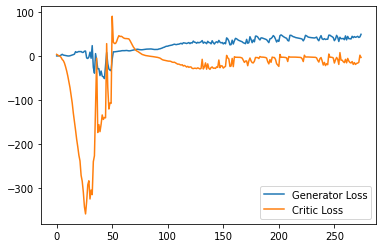

Epoch 12, step 6000: Generator loss: 43.87682008361816, critic loss: -11.932834959220878


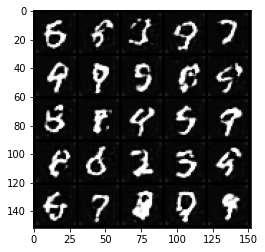

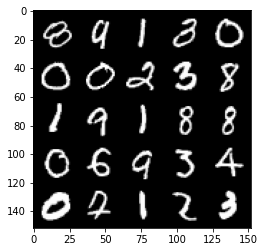

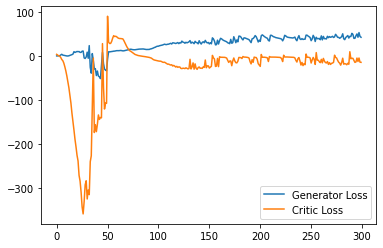

Epoch 13, step 6500: Generator loss: 48.876363601684574, critic loss: -10.805732335317138


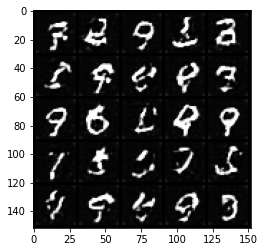

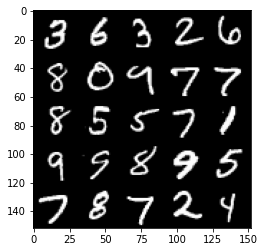

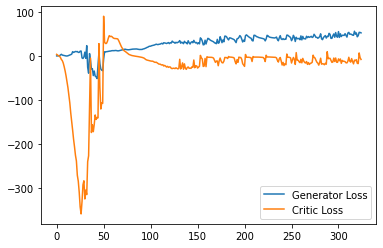

Epoch 14, step 7000: Generator loss: 46.717513816833495, critic loss: -12.352833603525177


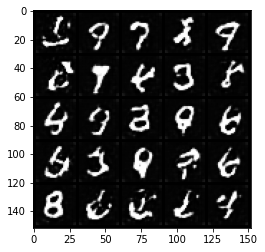

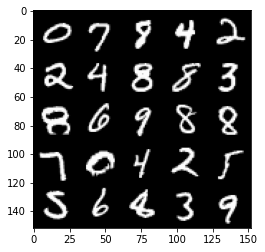

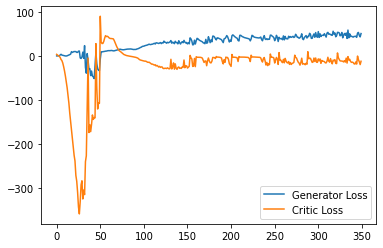

Epoch 15, step 7500: Generator loss: 47.18060020828247, critic loss: -14.165877031111712


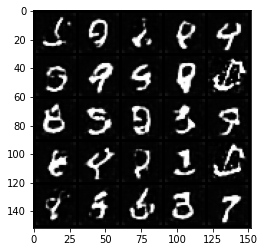

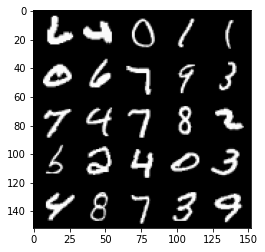

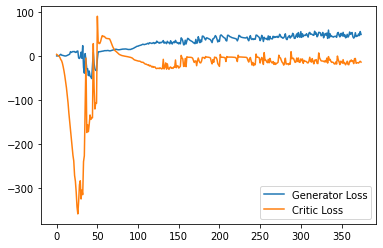

Epoch 17, step 8000: Generator loss: 46.11774156570434, critic loss: -10.937323558211324


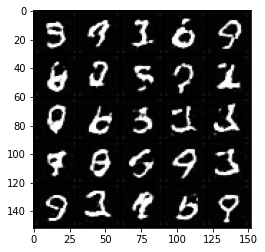

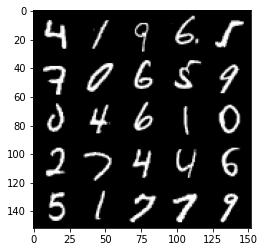

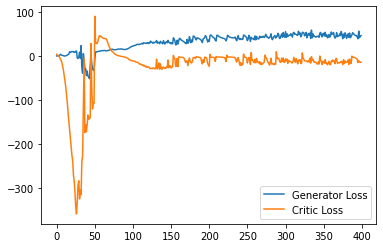

Epoch 18, step 8500: Generator loss: 47.86934345626831, critic loss: -14.172720692873007


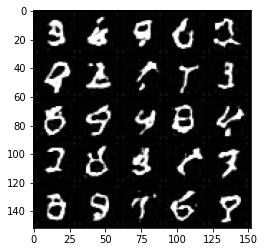

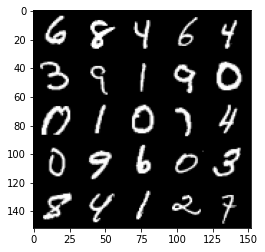

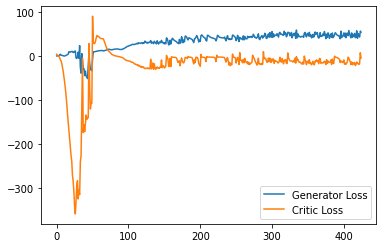

Epoch 19, step 9000: Generator loss: 50.21367493724823, critic loss: -13.701126245188707


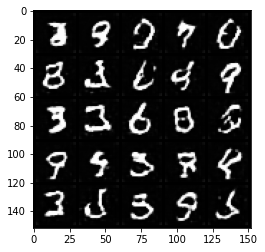

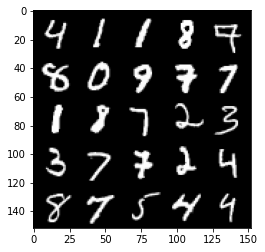

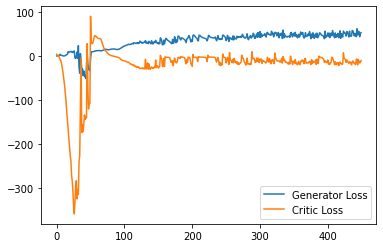

Epoch 20, step 9500: Generator loss: 48.246386207580564, critic loss: -13.056110733652112


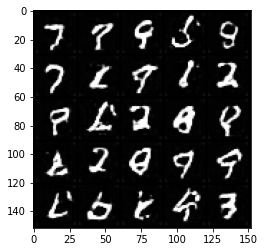

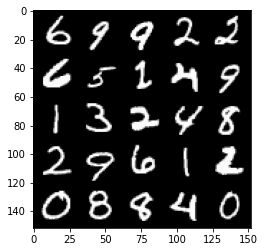

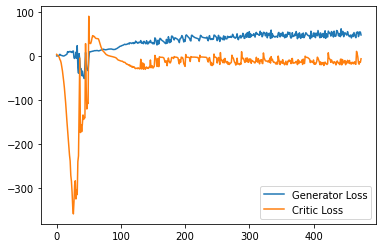

Epoch 21, step 10000: Generator loss: 44.1724391040802, critic loss: -16.924856139016143


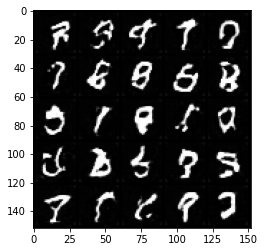

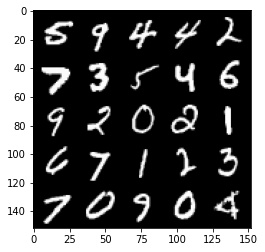

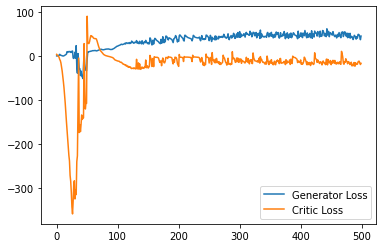

Epoch 22, step 10500: Generator loss: 43.5328450717926, critic loss: -14.088959230971332


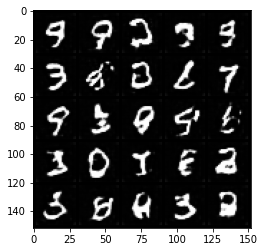

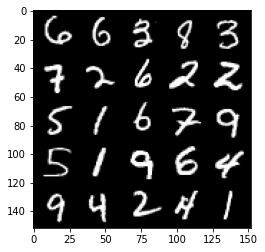

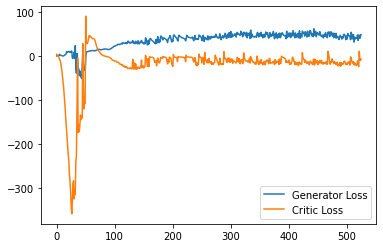

Epoch 23, step 11000: Generator loss: 44.20297812271118, critic loss: -15.309949341297155


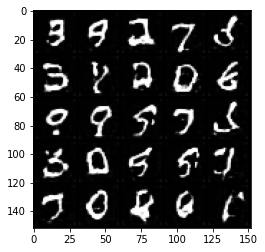

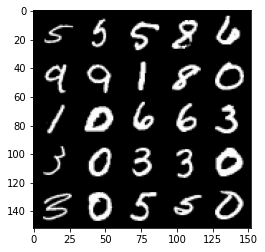

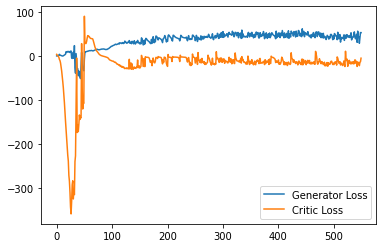

Epoch 24, step 11500: Generator loss: 40.68618320083618, critic loss: -15.251665971231446


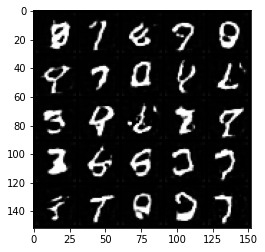

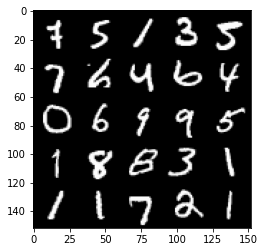

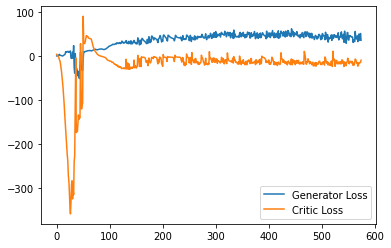

Epoch 25, step 12000: Generator loss: 40.66600040102005, critic loss: -14.157405856943134


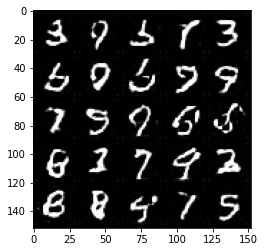

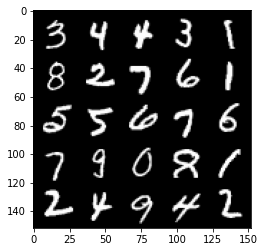

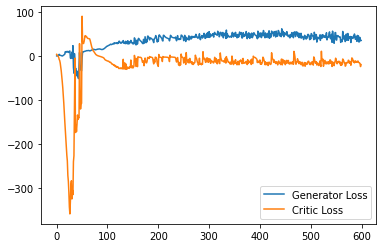

Epoch 26, step 12500: Generator loss: 40.51517752933502, critic loss: -14.114401430869105


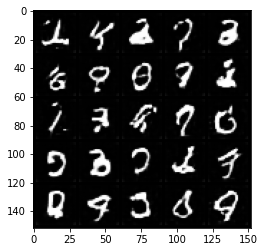

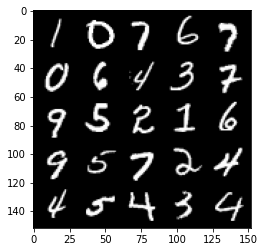

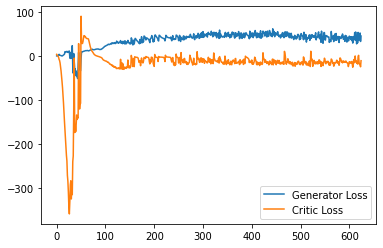

Epoch 27, step 13000: Generator loss: 37.05954617118835, critic loss: -14.594168150496483


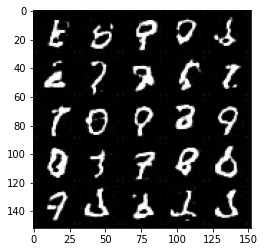

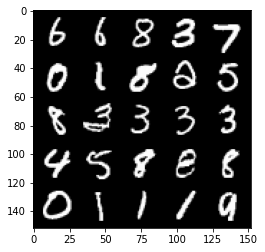

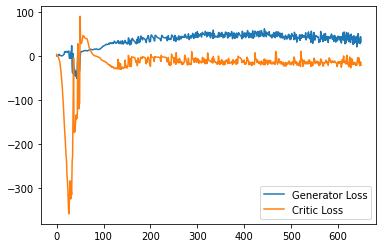

Epoch 28, step 13500: Generator loss: 36.72298464393616, critic loss: -14.917494813752164


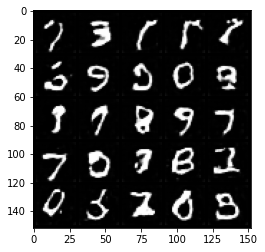

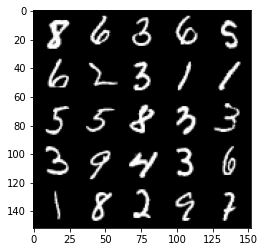

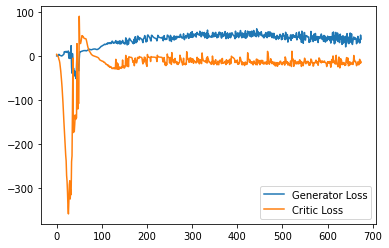

Epoch 29, step 14000: Generator loss: 41.13082195425034, critic loss: -4.327118082451819


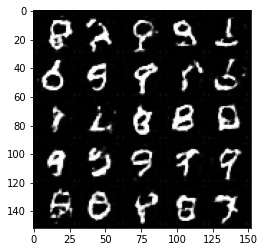

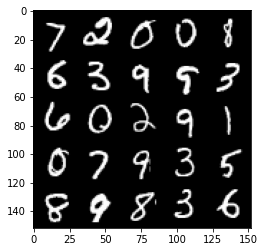

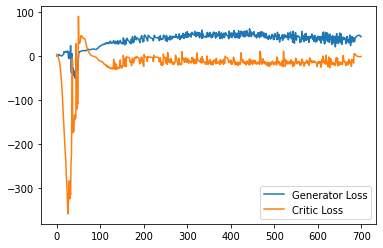

Epoch 30, step 14500: Generator loss: 42.79858592224121, critic loss: -1.8644304479599019


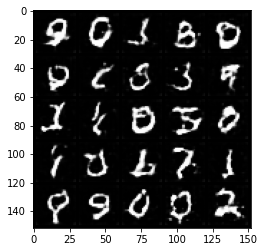

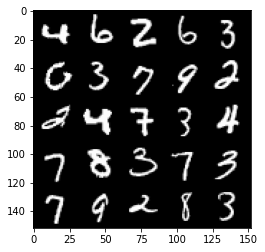

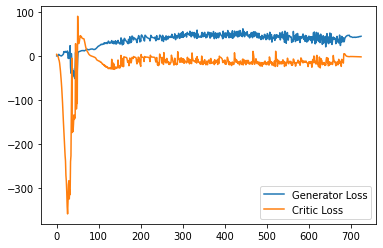

Epoch 31, step 15000: Generator loss: 49.00526404571533, critic loss: -2.9272952459096917


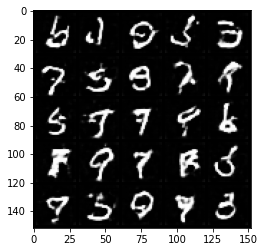

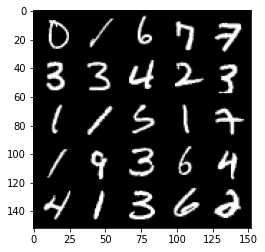

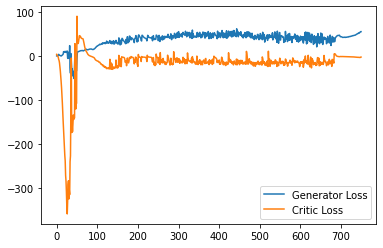

Epoch 33, step 15500: Generator loss: 58.33187079620361, critic loss: -4.055601957476138


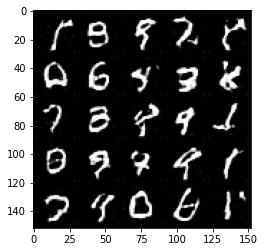

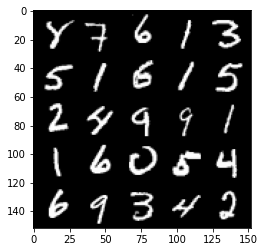

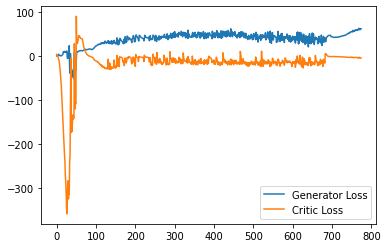

Epoch 34, step 16000: Generator loss: 65.00378524780274, critic loss: -4.738610500371456


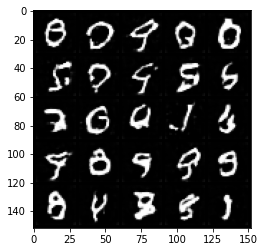

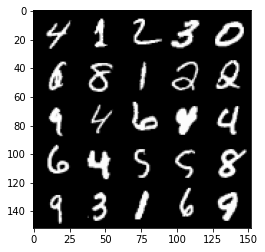

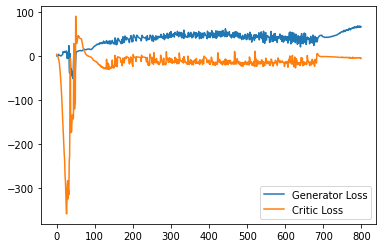

Epoch 35, step 16500: Generator loss: 68.72260820770263, critic loss: -5.493567038452626


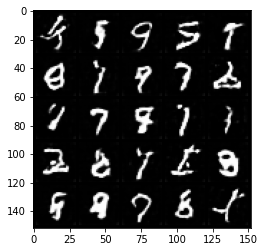

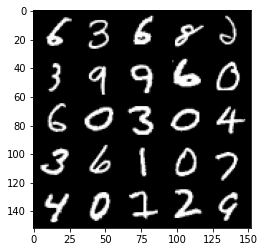

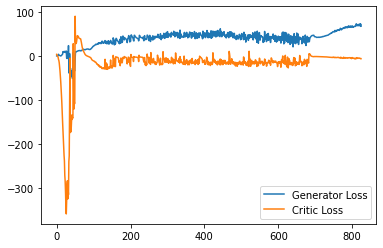

Epoch 36, step 17000: Generator loss: 72.72722068786621, critic loss: -6.072121793794635


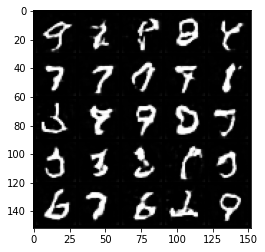

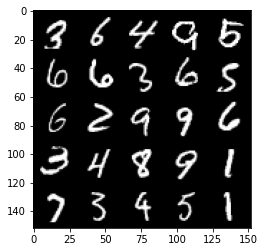

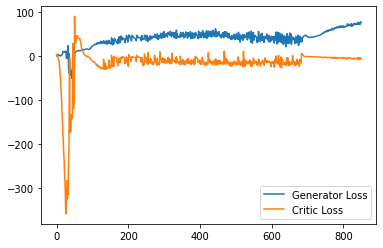

Epoch 37, step 17500: Generator loss: 75.13305414581299, critic loss: -6.203202494359016


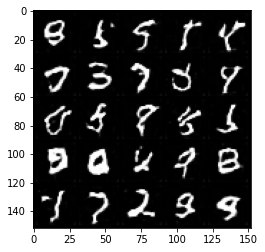

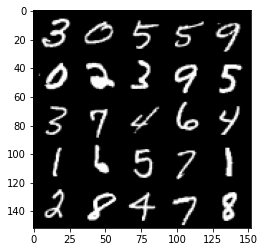

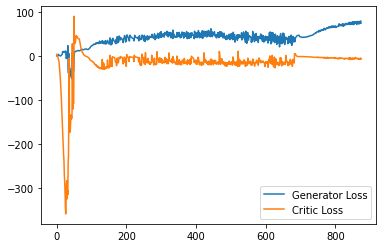

Epoch 38, step 18000: Generator loss: 76.61044163513183, critic loss: -6.070511528813836


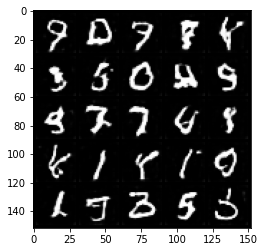

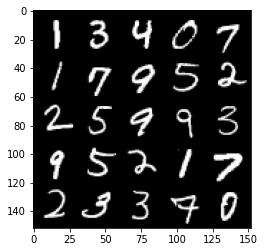

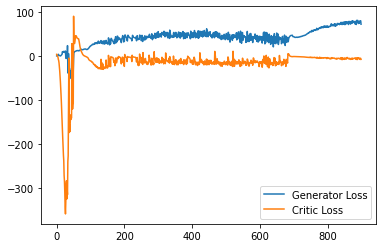

Epoch 39, step 18500: Generator loss: 80.38568589019775, critic loss: -6.593514253920321


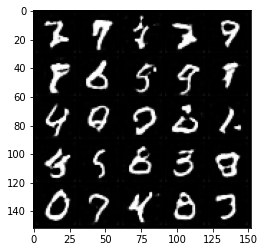

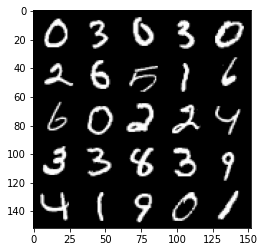

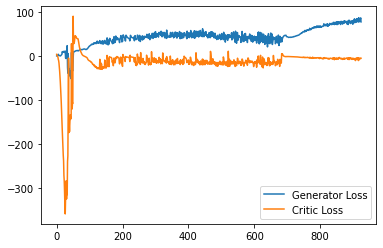

Epoch 40, step 19000: Generator loss: 83.28736987304687, critic loss: -6.880301256811616


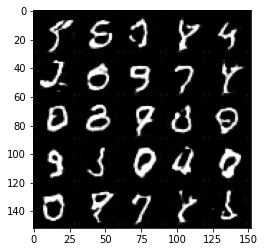

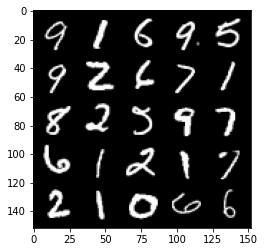

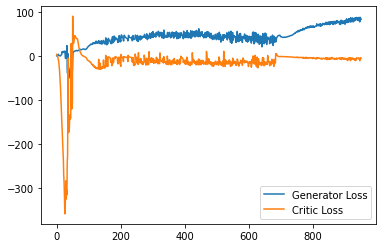

Epoch 41, step 19500: Generator loss: 87.1319119720459, critic loss: -7.645851097488407


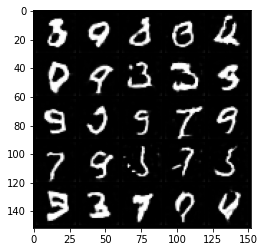

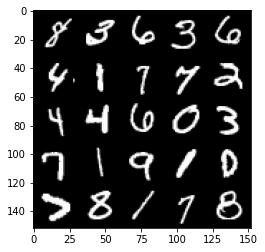

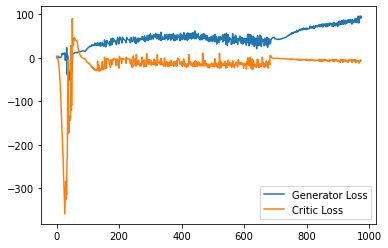

Epoch 42, step 20000: Generator loss: 92.8917046508789, critic loss: -6.011719485670331


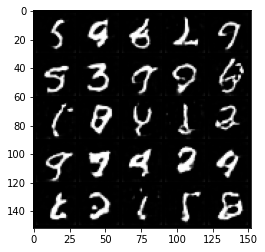

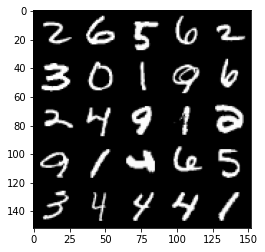

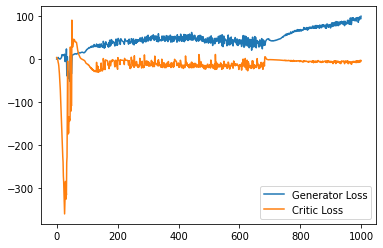

Epoch 43, step 20500: Generator loss: 95.49357098388671, critic loss: -7.641076654958732


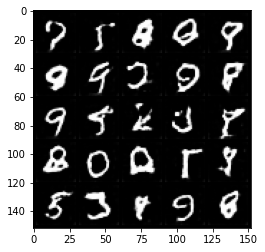

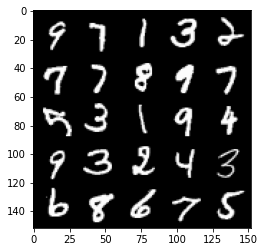

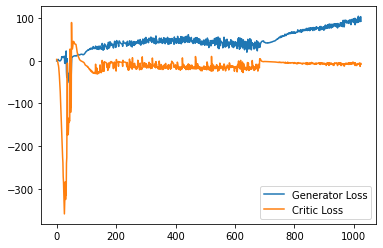

Epoch 44, step 21000: Generator loss: 98.43222634887695, critic loss: -7.285596925091741


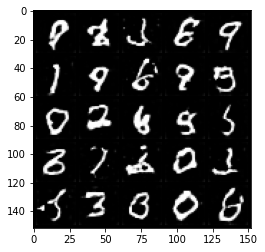

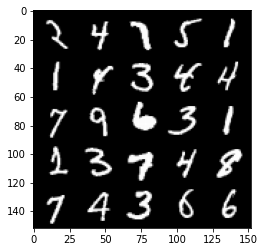

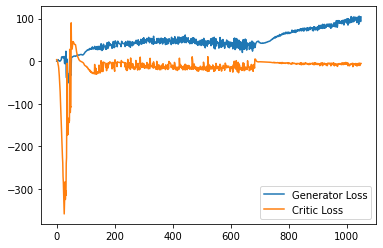

Epoch 45, step 21500: Generator loss: 101.46200686645508, critic loss: -6.758120586067442


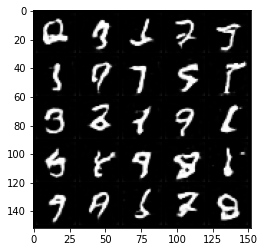

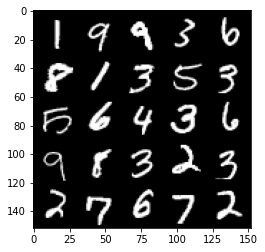

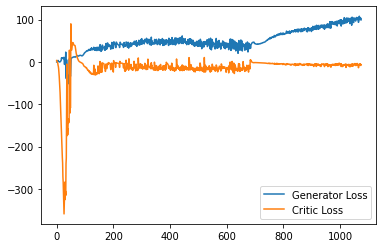

Epoch 46, step 22000: Generator loss: 104.13054138183594, critic loss: -8.462220679128164


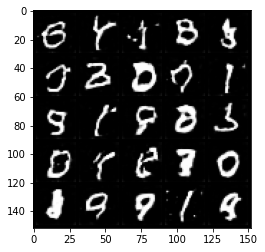

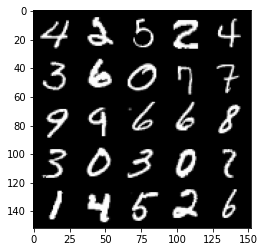

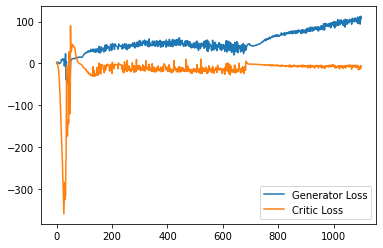

Epoch 47, step 22500: Generator loss: 105.17042854309082, critic loss: -7.0799013204097765


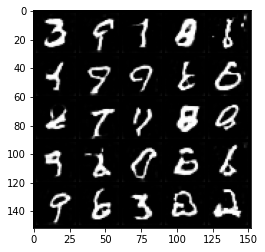

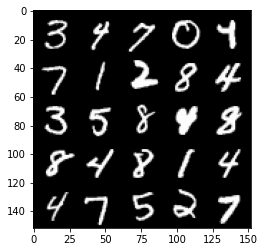

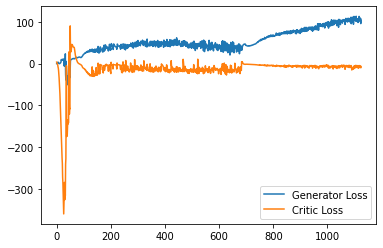

Epoch 49, step 23000: Generator loss: 107.67472706604003, critic loss: -7.5100553140401765


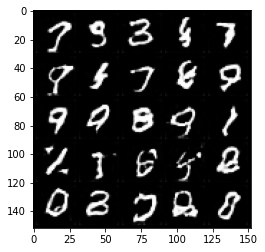

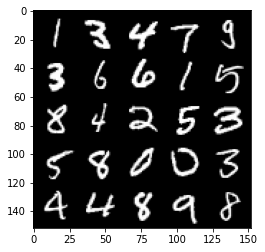

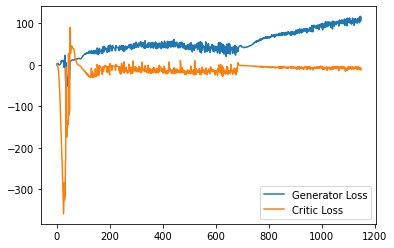

Epoch 50, step 23500: Generator loss: 110.69881144714356, critic loss: -8.244676603746418


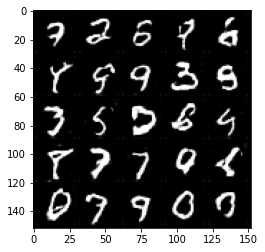

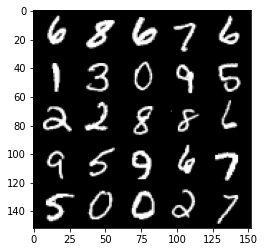

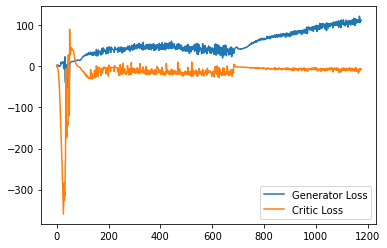

Epoch 51, step 24000: Generator loss: 112.84132301330567, critic loss: -8.712217529320716


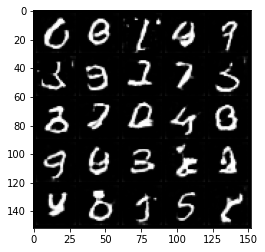

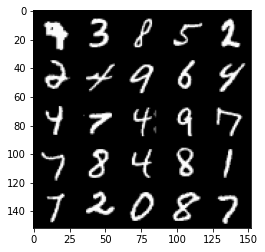

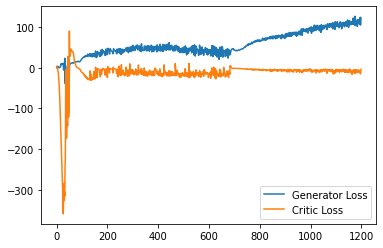

Epoch 52, step 24500: Generator loss: 116.00394602966308, critic loss: -7.726971493363382


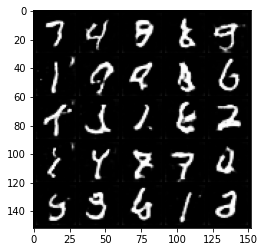

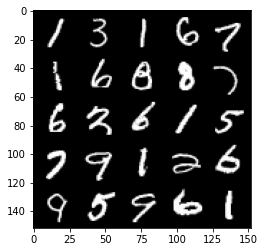

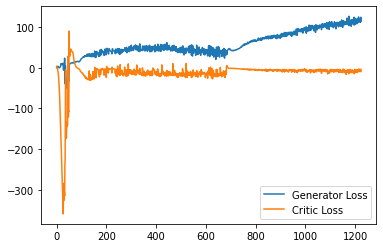

Epoch 53, step 25000: Generator loss: 119.56990739440919, critic loss: -8.195061529564853


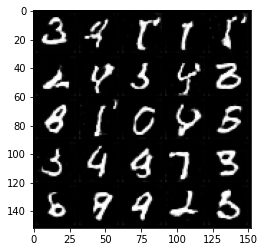

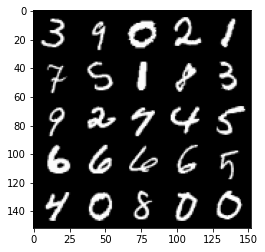

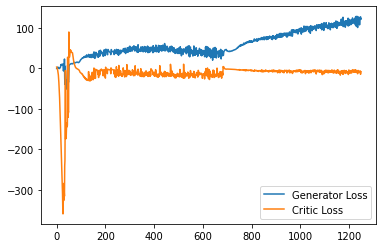

Epoch 54, step 25500: Generator loss: 119.1734379119873, critic loss: -8.680539641582968


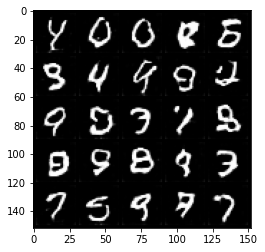

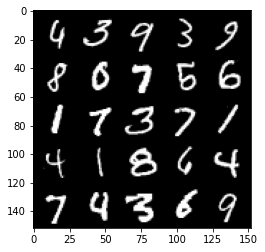

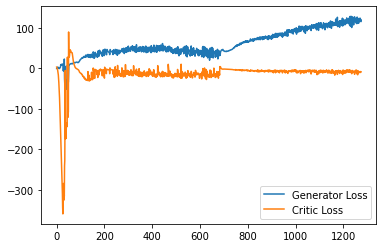

Epoch 55, step 26000: Generator loss: 121.40203218078614, critic loss: -8.917094346201411


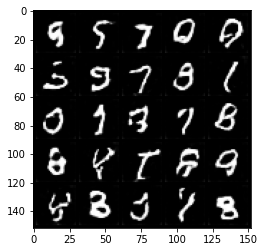

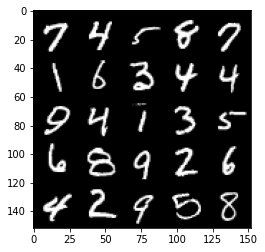

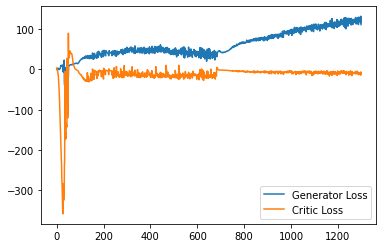

Epoch 56, step 26500: Generator loss: 124.54384130859376, critic loss: -9.77187604495286


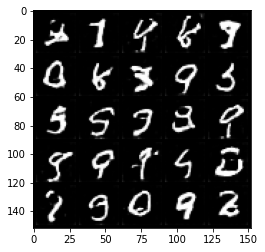

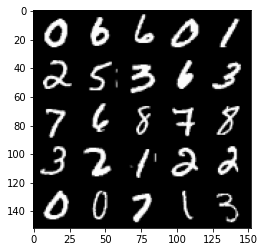

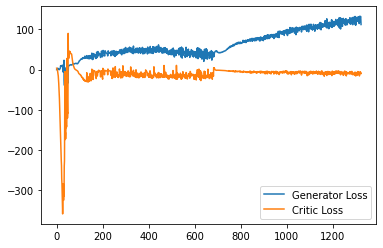

Epoch 57, step 27000: Generator loss: 128.17336582946777, critic loss: -9.730107037216426


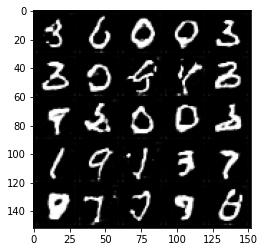

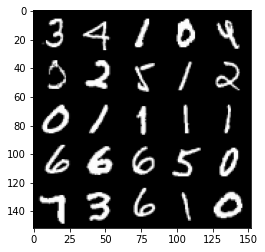

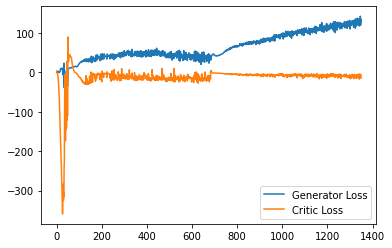

Epoch 58, step 27500: Generator loss: 130.02524244689943, critic loss: -8.828718955278397


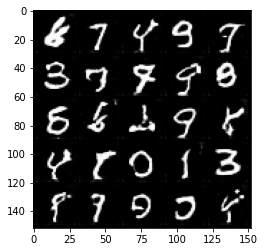

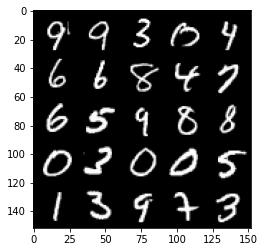

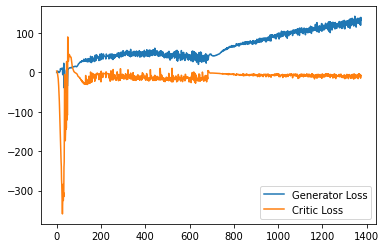

Epoch 59, step 28000: Generator loss: 133.7664553375244, critic loss: -9.682839377856249


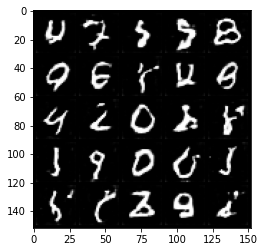

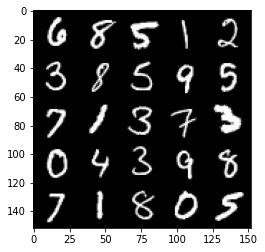

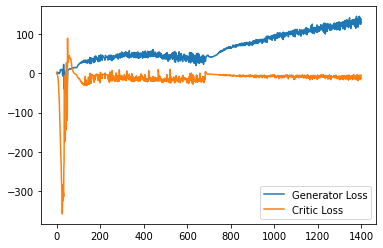

Epoch 60, step 28500: Generator loss: 135.37691096496582, critic loss: -10.256037993162868


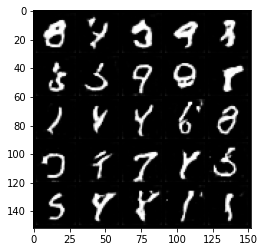

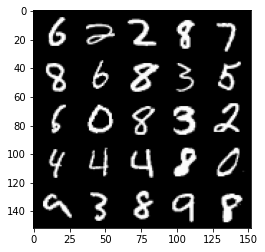

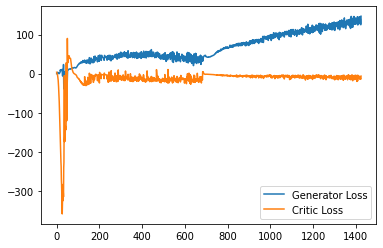

Epoch 61, step 29000: Generator loss: 138.3604930267334, critic loss: -10.093704350507261


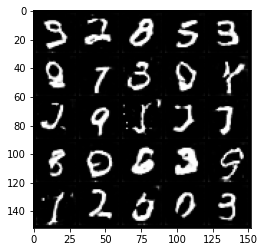

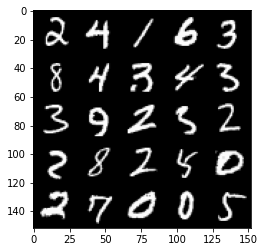

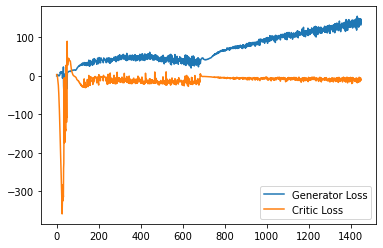

Epoch 62, step 29500: Generator loss: 141.40254234313966, critic loss: -8.836505028808107


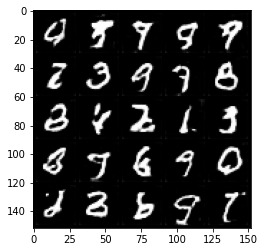

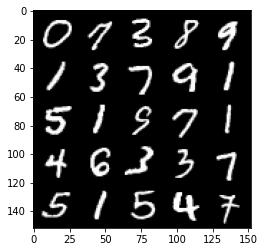

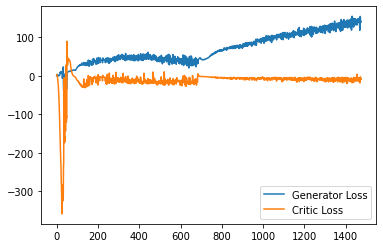

Epoch 63, step 30000: Generator loss: 144.98922914123534, critic loss: -9.875891783261299


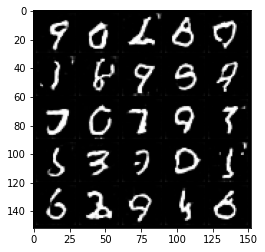

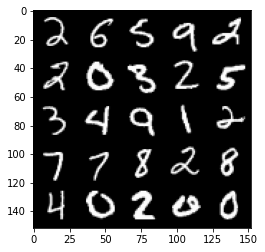

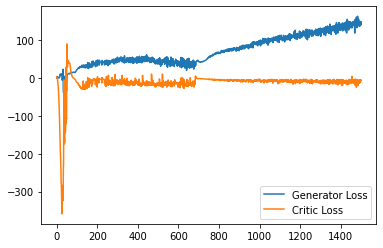

In [ ]:
import matplotlib.pyplot as plt

cur_step = 0
generator_losses = []
critic_losses = []
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_fimages(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()
        # Sample and save images
        save_fake_images(epoch+1)
        cur_step += 1


In [17]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'wgan_training_mnist.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()
out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 10, (152,152))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('wgan_training_mnist.avi')

D:\FULL DATA SCIENTIST\Courses\GAN Specialization\COurse 1\WGAN_MNIST\wgan_training_mnist.avi

In [11]:
# Save the model checkpoints 
torch.save(gen.state_dict(), 'G.pth')
torch.save(crit.state_dict(), 'D.pth')

In [13]:
plt.plot(critic_losses, '-')
plt.plot(generator_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [19]:
#plt.plot(real_scores, '-')
#plt.plot(fake_scores, '-')
#plt.xlabel('epoch')
#plt.ylabel('score')
#plt.legend(['Real', 'Fake'])
#plt.title('Scores');